In [1]:
import numpy as np
import sympy
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True
sympy.init_printing(use_latex=True, scale=1.0, forecolor="black", latex_mode="equation")

Consider an unbranched linear pathway of $n$ enzyme-catalyzed steps:
$$S_0 \overset{v_1}{\rightleftharpoons} S_1 \overset{v_2}{\rightleftharpoons} S_1 \overset{v_3}{\rightleftharpoons} \ldots\overset{v_n}{\rightleftharpoons} S_n$$

Each reaction is catalyzed by one enzyme, whose abundnace is represented by $\varepsilon_i$. The metabolite concentration for the pool $S_i$ is marked by $s_i$.

We consider four cases where the rate laws of all enzymes are:

|   Rate law       | Formula                                                                                                                          |
|------------------|----------------------------------------------------------------------------------------------------------------------------------|
| Michaelis-Menten | $v_i = \varepsilon_i ~ k_\rm{cat,i} ~ \frac{s_{i-1}}{s_{i-1} + K_{\rm{M},i}}$                                                    |
| Thermodyanmic    | $v_i = \varepsilon_i ~ k_\rm{cat,i} ~ (1 - e^{-\theta_i})$                                                                       |
| Mass-action      | $v_i = \varepsilon_i ~ k_\rm{cat,i} ~ (1 - e^{-\theta_i}) ~ s_{i-1}/K_{\rm{M},i}$                                                |
| Haldane          |$v_i =  \varepsilon_i ~ k_\rm{cat,i} ~(1 - e^{-\theta_i}) \frac{s_{i-1} / K_{\rm{S},i}}{1 + s_{i-1}/K_i^S + s_{i}/K_{\rm{P},i}}$  |


where $k_\rm{cat,i}$ are the enzyme turnover numbers (or specific activities), $K_\rm{M,i}$ (as well as $K_\rm{S,i}$ and $K_\rm{P,i}$) are their Michaelis-Menten constants, and $\theta_i$ are the driving forces defined by $\theta_i = \ln(K_{eq}) + \ln(s_{i}/s_{i-1})$.

We further assume that the total enzyme concentration if bounded by $\varepsilon_{tot}$, and that the system is at a given steady-state flux $J$ (where $s_0$ and $s_n$ are balanced by external reactions).

# The Michaelis-Menten rate law

If each enzyme obeys the following rate law:
$$v_i = \varepsilon_i ~ k_\rm{cat,i} ~ \frac{s_{i-1}}{s_{i-1} + K_\rm{M,i}}.$$
$k_\rm{cat,i}$ is the turnover number, $s_{i-1}$ is the concentration of metabolite number $(i-1)$, which is the substrate of reaction $i$.

Assume that the sum of all metabolite concentrations is bounded by $s_{tot}$. The maximal possible value for $J$ is given by:

$$J^* = \frac{\varepsilon_{tot}} {\sum_i 1 / k_\rm{cat,i} + \left( \sum_i \sqrt{K_\rm{M,i} / k_\rm{cat,i}} \right)^2/s_{tot}}$$

## Example: solutions for a model with 3 reactions

In [2]:
# define variables and parameters:
S_tot = sympy.Symbol("s_{tot}")
E_tot = sympy.Symbol("E_{tot}")
E = sympy.symbols("E_1 E_2 E_3")
v = sympy.symbols("v_1 v_2 v_3")
S = sympy.symbols("s_0 s_1 s_2 s_3")
kcat = sympy.symbols("k_{cat1} k_{cat2} k_{cat3}")
Km = sympy.symbols("K_{M1} K_{M2} K_{M3}")
symb_J_opt = sympy.symbols("J^{opt}")
symb_E_opt = sympy.symbols("E_1^{opt} E_2^{opt} E_3^{opt}")

# write expression for the rate laws and optimal solution:
ratelaws = [sympy.Equality(v[i], E[i] * kcat[i] * S[i]/(S[i] + Km[i])) for i in range(3)]

sum_of_roots = sum([sympy.sqrt(Km[i] / kcat[i]) for i in range(3)])

J_opt = sympy.Equality(
    symb_J_opt, E_tot / (
        1/sum([1/k for k in kcat])
        +
        sum_of_roots**2 / S_tot
    )
)

E_opt = [
    sympy.Equality(
        symb_E_opt[i],
        J_opt.lhs * (1/kcat[i] + sympy.sqrt(Km[i] / kcat[i]) * sum_of_roots / S_tot)) for i in range(3)
]

Rate laws:


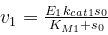

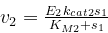

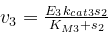

In [3]:
print("Rate laws:")
for r in ratelaws:
    display(r)

Maximal flux:


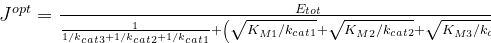

In [4]:
print("Maximal flux:")
display(J_opt)

In [5]:
print("Optimal enzyme allocations:")
for e in E_opt:
    display(e)

Optimal enzyme allocations:


# The thermodynamic rate law

Each enzyme obeys the following rate law:
$$v_i = \varepsilon_i ~ k_\rm{cat,i} (1 - e^{-\theta_i}).$$

Assume $s_0$ and $s_n$ have fixed concentrations (so the sum of all $\theta_i$ is constant, defined as $\theta$).

The maximal possible value for $J$ is given by:
$$J^* =  \frac{\varepsilon_{tot}} { \sum_i 1 / k_\rm{cat,i} \left( \frac{1}{2} + \frac{1}{2} \sqrt{1 + k_\rm{cat,i}/\Psi} \right)}$$
where to find $\Psi$, we need to invert the following function:
$$\theta = 2 \sum_i \ln\left(\sqrt{\Psi/k_\rm{cat,i}} + \sqrt{1 + \Psi/k_\rm{cat,i}} \right)$$

Fortunately, this latter function is strictly increasing in the range $\Psi \in [0, \infty)$, going from $0$ to $\infty$, which means that the inverse is well-defined for any $\theta \geq 0$.

## Example: a model with 5 reactions

In this example, we use a non-linear optimization solver to find the maximal flux, and then compare the result to our analytical solution.

In [6]:
n = 5 # nunber of reactions
E_tot = 1 # total enzyme
k_cat = np.array([0.2, 0.7, 4.0, 2.0, 0.1], dtype=float)
theta = 10 # total driving force (also the constrain on the sum of the driving force variables: (theta_1, theta_2, ... theta_n)
def J(theta) -> float:
    return E_tot / (  k_cat**(-1) @ (1 - np.exp(-theta))**(-1) )

constraints = [
    LinearConstraint(A=np.matrix(np.ones(n)), lb=theta*np.ones(1), ub=theta*np.ones(1))
]
bounds = Bounds(np.ones(n)*1e-10, np.ones(n)*np.inf) # ensure each theta_i must is a positive number (and not too close to 0 to avoid numerical issues)
initial_theta = np.ones(n) * (theta / n)

In [7]:
res = minimize(
    lambda theta: -J(theta),
    x0 = initial_theta,
    constraints=constraints,
    bounds=bounds,
    tol=1e-10
)
theta_opt = res.x

From our analytical solution, we know that the optimal driving forces all should satisfy:
$$\theta_i = 2 \textrm{sinh}^{-1}(\sqrt{\Psi/k_\rm{cat,i}})$$
which can be inverted to get:
$$\Psi = \textrm{sinh}^2(\theta_i/2)~k_\rm{cat,i}$$
so, we can simply check that indeed all $\theta_i$ give the (almost) same value by plotting the values next to each other in a bar plot.

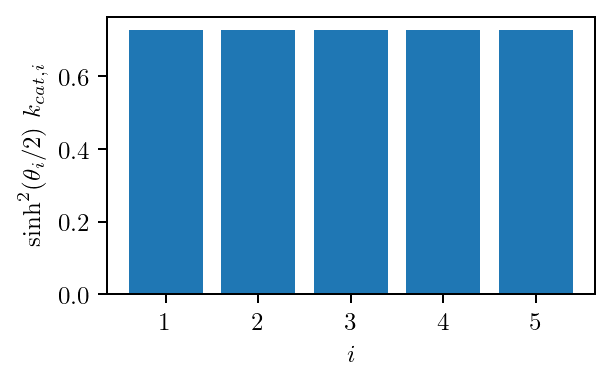

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2), dpi=180)
ax.bar(x=range(1,n+1), height=np.sinh(theta_opt/2)**2 * k_cat)
ax.set_xlabel(r"$i$");
ax.set_ylabel(r"$\sinh^2(\theta_i/2)~k_{cat,i}$");

# The mass-action rate law

If each enzyme obeys the following rate law:
$$v_i = \varepsilon_i ~ k_\rm{cat,i} ~ (1 - e^{-\theta_i}) ~ s_{i-1}/K_{\rm{M},i}.$$

The maximal possible value for $J$ is given by:

$$\gamma_i \equiv K_{\rm{M},i}/k_\rm{cat,i} \prod_{j=i}^{n} K_\rm{eq,j}$$

$$||\mathbf{\gamma}||_\frac{1}{2} \equiv \left( \sum_j \sqrt{\gamma_j} \right)^2$$

$$J_{opt} = \frac{\varepsilon_{tot}}{ ||\mathbf{\gamma}||_\frac{1}{2}} \cdot \left(s_0~K_\text{eq} - s_n\right) $$

## Example: solutions and simulations for a model with 3 reactions

In [9]:
# define variables and parameters:
S_tot = sympy.Symbol("S_{tot}")
E_tot = sympy.Symbol("E_{tot}")
E = sympy.symbols("E_1 E_2 E_3")
v = sympy.symbols("v_1 v_2 v_3")
S = sympy.symbols("S_0 S_1 S_2 S_3")
k_f = sympy.symbols("k_1 k_2 k_3")
k_r = sympy.symbols("k_{-1} k_{-2} k_{-3}")
symb_J_opt = sympy.symbols("J^{opt}")
symb_E_opt = sympy.symbols("E_1^{opt} E_2^{opt} E_3^{opt}")

# write expression for the rate laws and optimal solution:
ratelaws = [sympy.Equality(v[i], E[i] * (k_f[i] * S[i] - k_r[i] * S[i+1])) for i in range(3)]
Keq = k_f[0] * k_f[1] * k_f[2] / (k_r[0] * k_r[1] * k_r[2])
a = []
for j in range(3):
    a_j = 1/k_r[j]
    for i in range(j):
        a_j *= k_r[i]/k_f[i]
    a.append(a_j)
a_norm = sum([sympy.sqrt(a[i]) for i in range(3)])**2
J_opt = sympy.Equality(symb_J_opt, E_tot * a_norm * (S[0] - S[3] / Keq))
E_opt = [sympy.Equality(symb_E_opt[i], J_opt.lhs * sympy.sqrt(a[i] / a_norm)) for i in range(3)]

In [10]:
print("Rate laws:")
for r in ratelaws:
    display(r)

Rate laws:


Maximal flux:


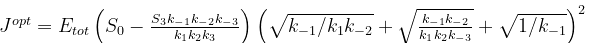

In [11]:
print("Maximal flux:")
display(J_opt)

Optimal enzyme allocations:


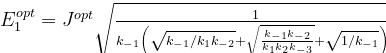

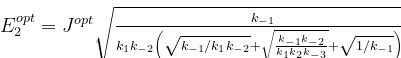

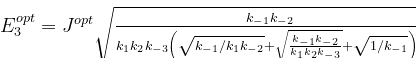

In [12]:
print("Optimal enzyme allocations:")
for e in E_opt:
    display(e)

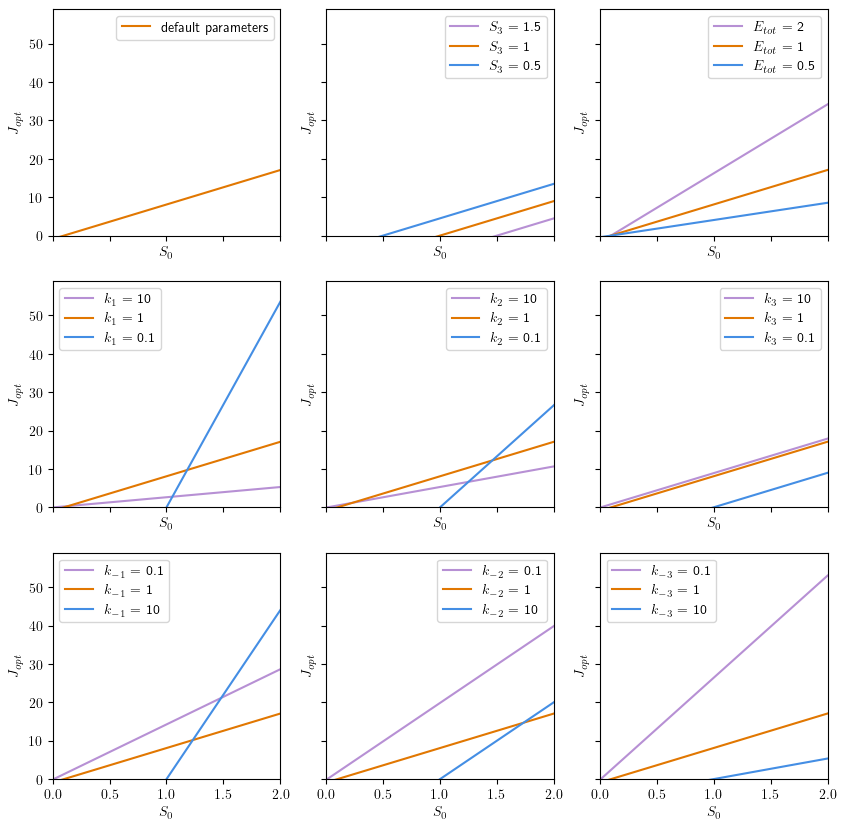

In [13]:
colors = ["#b790d4", "#e17701", "#448ee4"]

params = {
    S[3]: 0.1,
    k_f[0]: 1,
    k_f[1]: 1,
    k_f[2]: 1,
    k_r[0]: 1,
    k_r[1]: 1,
    k_r[2]: 1,
    E_tot: 1,
}
f = J_opt.rhs

S_0_range = np.linspace(0, 2, 50)
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100, sharex=True, sharey=True)

ax = axs[0, 0]
_f = sympy.lambdify(S[0], f.subs(params))
ax.plot(S_0_range, _f(S_0_range), label=f"default parameters", color=colors[1])

ax = axs[0, 1]
for s, c in zip([1.5, 1, 0.5], colors):
    p = params.copy()
    p[S[3]] = s
    _f = sympy.lambdify(S[0], f.subs(p))
    ax.plot(S_0_range, _f(S_0_range), label=f"$S_3$ = {s}", color=c)

ax = axs[0, 2]
for e, c in zip([2, 1, 0.5], colors):
    p = params.copy()
    p[E_tot] = e
    _f = sympy.lambdify(S[0], f.subs(p))
    ax.plot(S_0_range, _f(S_0_range), label=f"$E_{{tot}}$ = {e}", color=c)


for i in range(3):
    ax = axs[1, i]
    for k, c in zip([10, 1, 0.1], colors):
        p = params.copy()
        p[k_f[i]] = k
        _f = sympy.lambdify(S[0], f.subs(p))
        ax.plot(S_0_range, _f(S_0_range), label=f"$k_{{ {i+1} }}$ = {k}", color=c)

for i in range(3):
    ax = axs[2, i]
    for k, c in zip([0.1, 1, 10], colors):
        p = params.copy()
        p[k_r[i]] = k
        _f = sympy.lambdify(S[0], f.subs(p))
        ax.plot(S_0_range, _f(S_0_range), label=f"$k_{{ -{i+1} }}$ = {k}", color=c)

for ax in axs.flat:
    ax.set_xlabel(r"$S_0$")
    ax.set_ylabel(r"$J_{opt}$")
    ax.set_xlim(0, 2)
    ax.set_ylim(0, None)
    ax.legend()

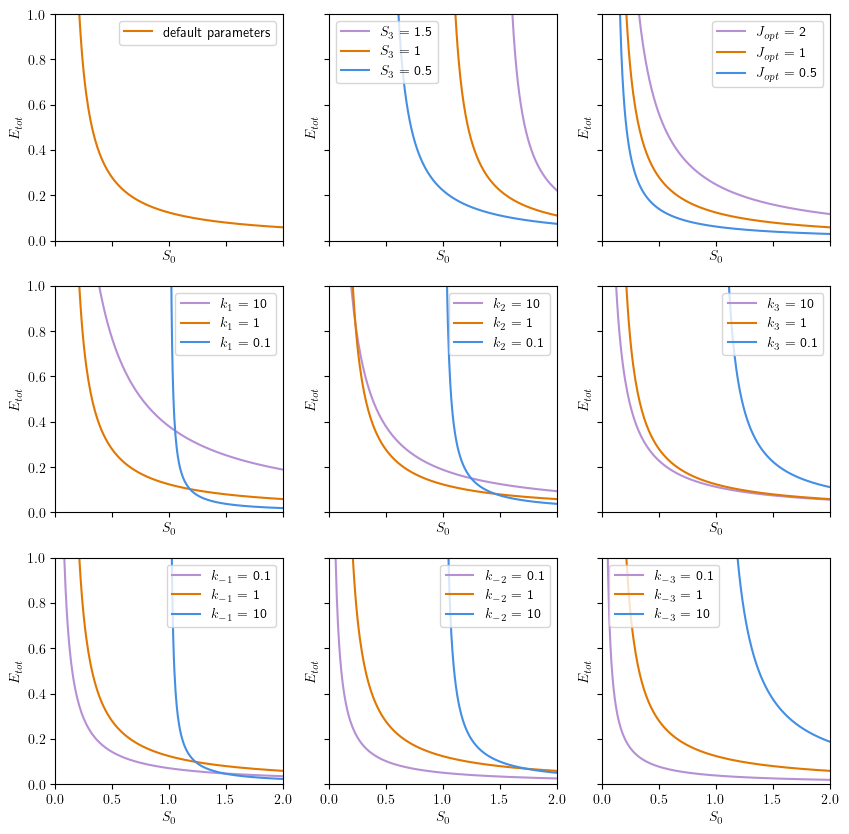

In [14]:
params = {
    S[3]: 0.1,
    k_f[0]: 1,
    k_f[1]: 1,
    k_f[2]: 1,
    k_r[0]: 1,
    k_r[1]: 1,
    k_r[2]: 1,
    symb_J_opt: 1,
}
f = sympy.solve(J_opt, E_tot)[0]

# now plot the enzyme demand per flux:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100, sharex=True, sharey=True)

ax = axs[0, 0]
_f = sympy.lambdify(S[0], f.subs(params))
S_0_range = np.linspace(0.1 + 1e-6, 2, 200)
ax.plot(S_0_range, _f(S_0_range), label=f"default parameters", color=colors[1])

ax = axs[0, 1]
for s, c in zip([1.5, 1, 0.5], colors):
    p = params.copy()
    p[S[3]] = s
    _f = sympy.lambdify(S[0], f.subs(p))
    S_0_range = np.linspace(s + 1e-6, 2, 200)
    ax.plot(S_0_range, _f(S_0_range), label=f"$S_3$ = {s}", color=c)

ax = axs[0, 2]
for J, c in zip([2, 1, 0.5], colors):
    p = params.copy()
    p[symb_J_opt] = J
    _f = sympy.lambdify(S[0], f.subs(p))
    S_0_range = np.linspace(0.1 + 1e-6, 2, 200)
    ax.plot(S_0_range, _f(S_0_range), label=f"$J_{{opt}}$ = {J}", color=c)

for i in range(3):
    ax = axs[1, i]
    for k, c in zip([10, 1, 0.1], colors):
        p = params.copy()
        p[k_f[i]] = k
        _f = sympy.lambdify(S[0], f.subs(p))
        S_0_range = np.linspace(0.1 / k + 1e-6, 2, 200)
        ax.plot(S_0_range, _f(S_0_range), label=f"$k_{{ {i+1} }}$ = {k}", color=c)

for i in range(3):
    ax = axs[2, i]
    for k, c in zip([0.1, 1, 10], colors):
        p = params.copy()
        p[k_r[i]] = k
        _f = sympy.lambdify(S[0], f.subs(p))
        S_0_range = np.linspace(0.1 * k + 1e-6, 2, 200)
        ax.plot(S_0_range, _f(S_0_range), label=f"$k_{{ -{i+1} }}$ = {k}", color=c)

for ax in axs.flat:
    ax.set_xlabel(r"$S_0$")
    ax.set_ylabel(r"$E_{tot}$")
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)
    #ax.set_yscale("log")
    ax.legend()

# The Haldane rate law

Consider an unbranched linear pathway of $n$ enzyme-catalyzed steps:
$$S_0 \rightleftharpoons S_1 \rightleftharpoons S_1 \rightleftharpoons \ldots \rightleftharpoons S_n$$
where each enzyme obeys the following rate law:
$$v_i = \frac{v_{+i}^{max} s_{i-1} / K_i^S  - v_{-i}^{max} s_{i} / K_i^P }{1 + s_{i-1}/K_i^S + s_{i}/K_i^P}.$$
$v_{+i}^{max}$ is the maximal forward velocity of reaction $i$, $v_{-i}^{max}$ is the maximal reverse velocity, $K_i^S$ and $K_i^P$ are the Michaelis-Menten coefficients of the substrate $s_{i-1}$ and product $s_{i}$.

If we assume steady state (i.e. that all fluxes $v_i$ are equal to $J$), we can find a recursive formula for $s_i$ based on all the other parameters (and $J$) [Klipp & Heinrich 1996]:
$$s_{i} = s_{i-1} \frac{K^P_i}{K^S_i} \frac{v_{+i}^{max}-J}{v_{-i}^{max}+J} - J \frac{K^P_i}{v_{-i}^{max} + J}$$

Solving this recursion we get that:
$$s_l = s_0 \left(\prod_{i=1}^l \frac{K^P_i}{K^S_i} \frac{v_{+i}-J}{v_{-i}+J}\right) - J \sum_{i=1}^l \frac{K^S_i}{v_{+i} - J} \prod_{j=i}^l \frac{K^P_j}{K^S_j} \frac{(v_{+j} - J)}{(v_{-j} + J)}$$

In [15]:
N = 2

J = sympy.Symbol("J")
s = [sympy.Symbol(f"s_{i}") for i in range(N+1)]
e = [sympy.Symbol(f"e_{i}") for i in range(1, N+1)]
v_f = [sympy.Symbol(f"v_{i}^f") for i in range(1, N+1)]
v_r = [sympy.Symbol(f"v_{i}^r") for i in range(1, N+1)]
K_s = [sympy.Symbol(f"K_{i}^S") for i in range(1, N+1)]
K_p = [sympy.Symbol(f"K_{i}^P") for i in range(1, N+1)]

fluxes = [
    (e[i] * v_f[i] * s[i] / K_s[i] - e[i] * v_r[i] * s[i+1] / K_p[i]) / (1 + s[i]/K_s[i] + s[i+1]/K_p[i])
    for i in range(N)
]

In [16]:
sympy_met_solutions = [s[0]]
sol = s[0]
for i in range(N):
    v = fluxes[i].subs(s[i], sol)
    sol = sympy.solve(sympy.Equality(J, v), s[i+1])[0]
    sympy_met_solutions.append(sol)


s_n = sol



In [17]:
ds_n_to_dJ = sympy.derive_by_array(s_n, [e[0]])
display(ds_n_to_dJ)

⎡                                      ⎛ 2                  2              2                                          
⎢K_2__P⋅(-J⋅v_1__r - e₂⋅v_1__r⋅v_2__r)⋅⎝J ⋅K_1__P⋅K_1__S + J ⋅K_1__P⋅s₀ - J ⋅K_1__S⋅K_2__S - J⋅K_1__P⋅K_1__S⋅e₂⋅v_2__f
⎢─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
⎢                                                                                                                     
⎢                                                                                            ⎛ 2                      
⎣                                                                              K_1__S⋅K_2__S⋅⎝J  + J⋅e₁⋅v_1__r + J⋅e₂⋅

                                                                                                            ⎞         
 - J⋅K_1__P⋅e₁⋅s₀⋅v_1__f - J⋅K_1__P⋅e₂⋅s₀⋅v_2__f - J⋅K_1__S⋅K_2__S⋅e₁⋅v_1__r + K_1__P⋅e₁⋅e₂⋅s₀⋅v_1__f⋅v_2__f⎠   K_2__P
───────────────────────────────────────────────

In [18]:
alphas = [K_s[i] / (v_f[i] - J) for i in range(N)]
betas = [K_p[i] / (v_r[i] + J) for i in range(N)]
gammas = [betas[i]/alphas[i] for i in range(N)]

# now try Edda's formula
eddas_met_solutions = []
for l in range(N+1):
    sol = s[0] * sympy.prod(gammas[:l])
    for i in range(l):
        sol -= J * K_s[i] / (v_f[i] - J) * sympy.prod(gammas[i:l])
    eddas_met_solutions.append(sol)

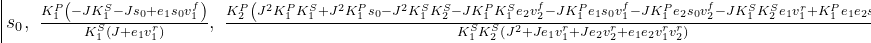

In [19]:
sympy_met_solutions

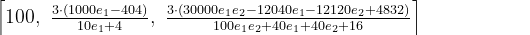

In [20]:
params = {}
input_params = {s[0] : 100, J : 4}
params.update({v_f[i] : 10 for i in range(N)})
params.update({v_r[i] : 10 for i in range(N)})
params.update({K_s[i] : 1 for i in range(N)})
params.update({K_p[i] : 3 for i in range(N)})

display([ss.subs(params).subs(input_params) for ss in sympy_met_solutions])
display([ss.subs(params).subs(input_params) for ss in eddas_met_solutions])

## Testing the correctness of the square-root law for the mass-action solution

Consider an unbranched linear pathway of $n$ enzyme-catalyzed steps:
$$S_0 \rightleftharpoons S_1 \rightleftharpoons S_1 \rightleftharpoons \ldots \rightleftharpoons S_n$$
where each enzyme obeys the following rate law:
$$v_i = E_i k_i (S_{i-1} - S_i).$$
$E_i$ is the enzyme level for step $i$, $k_i$ is the turnover number, $S_i$ is the concentration of the $i$th intermediate metabolite (which is the product of reaction $i$).

## Lemma 1

Assume $S_0$ and $S_n$ have fixed concentrations, that the total enzyme concentration is bound by $E_{tot}$, and that the system is at a given steady-state flux $J$ (where $S_0$ and $S_n$ are balanced by external reactions). The best allocation of $E_{tot}$ among the enzymes, which would maximize $J$, obeys:
$$E_i \propto k_i ^{-1/2}$$

In [21]:
import numpy as np
import sympy
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True
sympy.init_printing(use_latex=True, scale=2.0, forecolor="black", latex_mode="equation")

In [22]:
n = 20
v = np.ones(n)
k = np.exp(np.random.randn(n))
constraints = [
    LinearConstraint(A=np.matrix(np.ones(n)), lb=np.ones(1), ub=np.ones(1))
]
bounds = Bounds(np.ones(n)*1e-5, np.ones(n)*np.inf)

In [23]:
def E_tot(dS) -> float:
    return (v / k) @ (1.0 / dS)

In [24]:
res = minimize(
    E_tot,
    x0 = np.ones(n),
    constraints=constraints,
    bounds=bounds
)
dS = res.x

E = v / (k * dS)

/home/eladn/git/optimal_enzyme_investment/venv/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


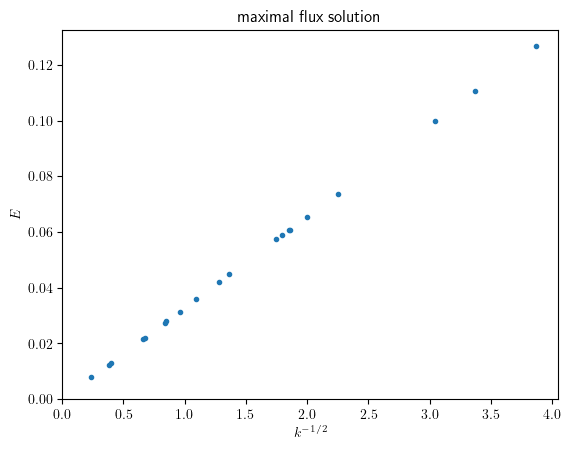

In [25]:
fig, ax = plt.subplots(1, 1)
ax.plot(k**(-0.5), dS, '.')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel(r"$k^{-1/2}$")
ax.set_ylabel(r"$E$")
ax.set_title("maximal flux solution");

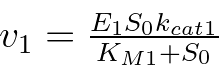

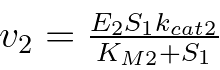

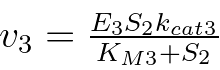

In [26]:
S_tot = sympy.Symbol("S_{tot}")
E_tot = sympy.Symbol("E_{tot}")
E = sympy.symbols("E_1 E_2 E_3")
v = sympy.symbols("v_1 v_2 v_3")
S = sympy.symbols("S_0 S_1 S_2 S_3")
kcat = sympy.symbols("k_{cat1} k_{cat2} k_{cat3}")
Km = sympy.symbols("K_{M1} K_{M2} K_{M3}")
a = [Km[i] / kcat[i] for i in range(3)]
ratelaws = [sympy.Equality(v[i], E[i] * kcat[i] * S[i]/(S[i] + Km[i])) for i in range(3)]

for r in ratelaws:
    display(r)